# Métodos de Interpolación

## Introducción

La siguiente tabla muestra las propiedades del agua en función de la temperatura.

<img src="./images/thermodynamic_properties.png" width="800" align= center>

En ingeniería generalmente debemos utilizar estas tablas. Si quisieramos determinar, por ejemplo, el valor de la densidad a $10\mathrm{^oC}$ necesitaríamos conocer la función $\rho(T)$, ya que el valor no está en la tabla.

¿Cuál es la función más adecuada para representar la densidad?

A diferencia de nuestro problema de ajuste por mínimos cuadrados, en este caso cada valor de la tabla es certero. Es decir, **nuestra función debe pasar estrictamente por cada valor indicado en la tabla**.

Llamamos a esta función, **función de interpolación** y en esa clase revisaremos diferentes métodos para generarla.

## Interpolación Polinomial

Este método **consiste en determinar una único polinomio de interpolación que pase por todos los puntos tabulados.**

Matemáticamente, se puede demostrar que **para una série de $n+1$ valores tabulados ($x_i, y_i$ con $i = 0,1,\cdots), n$, existe un único polinomio de grado $n$:**

\begin{equation*}
f(x) = a_0 + a_1x + a_2x^2 + \cdots + a_nx^n
\end{equation*}

**que pasa por todos los $x_i, y_i$.**

La forma más intuitiva para encontrar los coeficientes es formar "$n+1$" ecuaciones considerando la intersección con los $n+1$ datos. Sin embargo, este método no es eficiente.

Por esta razón, se han desarrollado múltiples métodos para encontrar el polinomio de forma eficiente (polinomios de [Newton](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter17.05-Newtons-Polynomial-Interpolation.html), [Lagrange](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter17.04-Lagrange-Polynomial-Interpolation.html), etc).

### Polinomio de Interpolación mediante `numpy.polyfit`

En python, la forma más simple de generar un polinomio de interpolación es mediante `polyfit`.

Estrictamente hablando, `polyfit` es un método de regresión lineal y, por lo tanto, no está clasificado como método de interpolación. Sin embargo, es importante entender que **ajustar un polinomio de grado $n$ con un set de $n+1$ datos tabulados, es equivalente a resolver un sistema de $n$ ecuaciones lineales con $n$ incognitas (solución exacta).**

Por ejemplo, consideremos el polinomio de ajuste para la muestra:

```python
# Datos de la muestra xi, yi
xi = np.array([-5.0, -2.0, 0.5, 3.0, 5.0])
yi = np.array([-2.0, -0.1, 2.0, 1.0,-1.0])
```

Generaremos un **polinomio de grado 2** ($y= a_0 + a_1x + a_2x^2$) mediante ```polyfit```, considerando dos casos:
1. Todos los datos tabulados (ajuste por mínimos cuadrados).
```python
# polinomio de ajuste
ai = np.polyfit(xi,yi,2)
```

2. Solo los datos $\{x_0,y_0\}$; $\{x_2,y_2\}$ y $\{x_4,y_4\}$
```python
# polinomio de interpolación
ai = np.polyfit([xi[0], xi[2], xi[4]],[yi[0], yi[2], yi[4]],2)
```


In [1]:
%%capture showplot
import matplotlib.pyplot as plt
import numpy as np

# Datos de la muestra xi, yi
xi = np.array([-5.0, -2.0, 0.5, 3.0, 5.0])
yi = np.array([-2.0, -0.1, 2.0, 1.0,-1.0])

x = np.arange(-5, 5, .1) # arreglo en x para graficar

# polinomio de ajuste grado 2
ai = np.polyfit(xi,yi,2)
y_fit = np.polyval(ai,x)

# polinomio de interpolación grado 2
ai = np.polyfit([xi[0], xi[2], xi[4]],[yi[0], yi[2], yi[4]],2)
y_pol = np.polyval(ai,x)

plt.figure(figsize = (4, 3))           # Tamaño de figura
plt.rcParams.update({'font.size': 10}) # Tamaño de fuente

# ploteamos los dos polinomios
plt.plot(x, y_fit, '--k',label='modelo de ajuste')
plt.plot(x, y_pol, 'b',label='interpolación')
# ploteamos xi, yi
plt.plot(xi, yi, 'ro',label='_datos $(x_i, y_i)$')

plt.title('Polinomio grado 2 por mínimos cuadrados')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(frameon=False)
plt.show()

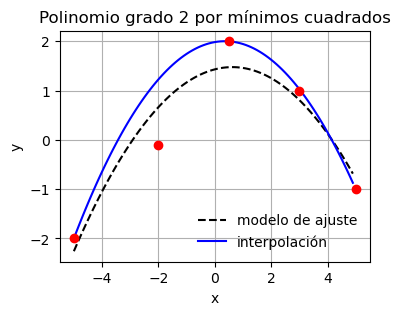

In [2]:
showplot()

Notar como **la curva azul pasa exáctamente por los puntos $\{x_i, y_i\} = \{-5.0, -2.0\}$, $\{0.5, 2.0\}$ y $\{5.0, -1.0\}$**

### Problemas de oscilación en interpolación polinomial
Un problema de los polinomios de interpolación es que **sufren problemas de oscilación a medida que aumenta el número de datos en la muestra**.

Este problema se conoce como el **fenómeno de Runge**, en referencia a Carl Runge, quién en 1901 demostró el mal condicionamiento de los polinomios de interpolación cuando se analizaba la siguiente función:

\begin{equation*}
f(x)=\frac{1}{1 + 25x^2}
\end{equation*}

Esta función se conoce como **función de Runge**

Analicemos este problema considerando el dominio $x\in\left[-1,1\right]$. Utilizando polinomios de interpolación de grado 5, $p_5(x)$ y grado 7, $p_7(x)$, generados por `polyfit`.

In [3]:
import numpy as np

# generamos la funcion Runge
f = lambda x: 1/(1+25*x**2)

# Polinomio con 5 datos igualmente espaciados
xi5 = np.linspace(-1,1,5)          # xi
yi5 = f(xi5)                       # yi 
p5 = np.polyfit(xi5,yi5,len(xi5)-1) # coeficientes del polinomio de interpolación

# Polinomio con 7 datos igualmente espaciados
xi7 = np.linspace(-1,1,7)          # xi
yi7 = f(xi7)                       # yi 
p7 = np.polyfit(xi7,yi7,len(xi7)-1) # coeficientes del polinomio de interpolación

Graficamos el resultado

In [4]:
%%capture showplot1
import matplotlib.pyplot as plt
plt.figure(figsize = (4, 3))           # Tamaño de figura
plt.rcParams.update({'font.size': 10}) # Tamaño de fuente

# arreglo para plotear
x = np.linspace(-1,1,100)

# ploteamos la función de Runge
plt.plot(x,f(x),'--k', label='Runge')

# ploteamos los polinomios de Lagrange
plt.plot(x, np.polyval(p5,x), 'r',label='polinomio grado 5')
plt.plot(x, np.polyval(p7,x), 'b',label='polinomio grado 7')

# ploteamos los xi, yi
# ! usamos '_' al comienzo del label para suprimir el output en "legend"
plt.plot(xi5, yi5, 'ro',label='_$x_i, y_i$ para $P_5(x)$') 
plt.plot(xi7, yi7, 'bo',label='_$x_i, y_i$ para $P_7(x)$')

plt.title('Problema de oscilación por interpolación')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(frameon=False)
plt.show()

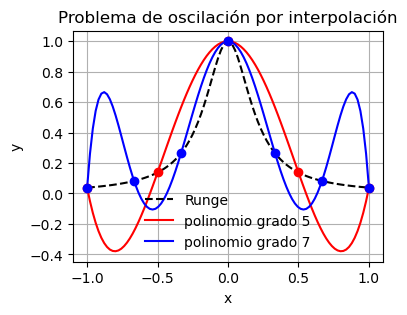

In [5]:
showplot1()

## Interpolación por tramos (*piecewise polynomial*)
Este es el método más confiable para evitar los problemas de oscilación, y el más utilizado en la actualidad


En este caso, para un set de $n+1$ datos $\{x_i, y_i\}$, con $i = 0,1,...,n$, el método de interpolación por tramos consiste en contruir $n$ polinomios de interpolación para los $n$ intervalos interiores.

<img src="./images/piecewise_interpolation.png" width="800px" align= center>

### Interpolación lineal (`numpy.interp`)
El **método de interpolación lineal consiste en construir $n$ rectas $\hat{y}_i(x)$,** cada una definida entre dos puntos $\{x_i, y_i\}$ y $\{x_{i+1}, y_{i+1}\}$ de la forma:

\begin{equation*}
\hat{y}_i(x) = y_i + \frac{y_{i+1} - y_{i}}{x_{i+1} - x_{i}}(x - x_{i}),\quad\quad x\in\left[x_i, x_{i+1}\right]
\end{equation*}

En python, esta función esta implementada en ```numpy.interp``` (ver documentación [acá](https://numpy.org/doc/stable/reference/generated/numpy.interp.html)). 

In [6]:
import numpy as np

# datos tabulados
xi = [0, 1, 2] # xi
yi = [1, 3, 2] # yi

x0 = 1.5                   # valor x para determinar
y0 = np.interp(x0, xi, yi) # interpolamos y(x) en x0 = 1.5
print('y0 = y(x0 = 1.5) =',y0)

y0 = y(x0 = 1.5) = 2.5


Podemos crear una función de interpolación lineal usando funciones `lambda` y `numpy interp`. Esto nos permite llamar al polinomio múltiples veces, sin tener que ingresar los datos tabulados repetitivamente.

In [7]:
# datos tabulados
xi = [0, 1, 2] # xi
yi = [1, 3, 2] # yi

y = lambda x: np.interp(x, xi, yi) # función de interpolación lineal

In [8]:
y(0.3) # x = 0.3

1.6

In [9]:
y(0.5) # x = 0.5

2.0

In [10]:
x = np.array([0.3, 0.5, 0.8]) # arreglo de datos 
y(x)

array([1.6, 2. , 2.6])

Este método es útil para graficar.

In [11]:
%%capture showplot2
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (4, 3))           # Tamaño de figura
plt.rcParams.update({'font.size': 10}) # Tamaño de fuente

# generamos datos para graficar y función de interpolación
x = np.linspace(0,2.0,100)             # 100 puntos entre 0 y 2

plt.plot(x, y(x), '-b', label='$y(x)$')             # graficamos la función
plt.plot(xi, yi, 'ob')                              # graficamos los xi, yi 
plt.plot(1.5, y(1.5), 'or', label='$y(x_0 = 1.5)$') # graficamos y(1.5)

plt.title('Interpolación lineal (interp1d de scipy)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(frameon=False)
plt.show()

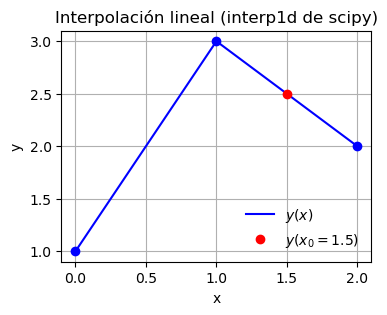

In [12]:
showplot2()

Por defecto, `numpy.interp` entregará los valores extremos cuando intentemos extrapolar.

In [13]:
%%capture showplot3
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (4, 3))           # Tamaño de figura
plt.rcParams.update({'font.size': 10}) # Tamaño de fuente

# generamos datos para graficar y función de interpolación
x = np.linspace(-1,3,100)             # 100 puntos entre 0 y 2

plt.plot(x, y(x), '-b', label='$y(x)$')             # graficamos la función
plt.plot(xi, yi, 'ob')                              # graficamos los xi, yi 
plt.plot(1.5, y(1.5), 'or', label='$y(x_0 = 1.5)$') # graficamos y(1.5)

plt.title('Interpolación lineal (interp1d de scipy)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(frameon=False)
plt.show()

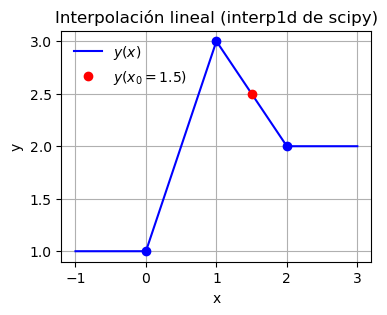

In [14]:
showplot3()

### *Spline* cúbico (`scipy.interpolate.CubicSpline`)
El *spline* cúbico consiste en generar una función de interpolación basado en una serie de polinomios cúbicos $S_i(x) = a_i x^3 + b_i x^2 + c_i x + d_i$, cada uno definido en el tramo $x\in\left[x_i, x_{i+1}\right]$

Para encontrar la función de interpolación debemos determinar los coecientes $a_i, b_i, c_i, d_i$ de cada $S_i(x)$.

Para una serie de $n+1$ datos tabulados $\{x_i, y_i\}$, con $i = 0,1,...,n$, se necesitan $n$ polinomios $S_i(x)$. Esto nos da un **total de $4n$ incognitas y, por lo tanto, necesitamos de $4n$ ecuaciones linealmente independientes.**

Primero, cada polinomio $S_i(x)$ debe intersectar los valores extremos del domino en el que está definido. En otras palabras:

\begin{eqnarray*}
S_i(x_{i-1}) &=& a_i (x_{i-1})^3 &+& b_i (x_{i-1})^2 &+& c_i (x_{i-1}) &+& d_i &=& y_{i-1},\quad &i& = 1,\ldots,n,\\
S_i(x_i) &=& a_i (x_{i})^3 &+& b_i (x_{i})^2 &+& c_i (x_{i}) &+& d_i &=& y_i,\quad &i& = 1,\ldots,n,
\end{eqnarray*}

esto nos da un total de $2n$ ecuaciones linealmente independientes

Para asegurar una unión suave entre cada tramo, imponemos como condición que **la primera y segunda derivada entre dos polinomios sean iguales en los nodos centrales.** Matemáticamente. 

\begin{eqnarray*}
S^{\prime}_i(x_{i}) &=& S^{\prime}_{i+1}(x_{i}),\quad i = 1,\ldots,n-1,\\
S''_i(x_{i}) &=& S''_{i+1}(x_{i}),\quad i = 1,\ldots,n-1,
\end{eqnarray*}

lo que nos da un total de $2(n - 1)$ ecuaciones linealmente independientes.

Las últimas dos ecuaciones se determinan por las condiciones de borde en los extremos $y(x_0)$,  $y(x_n)$. Tenemos distintas alternativas:

- ***Not a knot***. Imponemos una condición para la tercera derivada en los extremos, de manera que $S_1'''(x_1) = S_2'''(x_1)$ y $S_{n-1}'''(x_{n-1}) = S_n'''(x_{n-1})$

- ***Clamped***. La primera derivada en los extremos, $S_1'(x_0) = S_n'(x_n) = 0$

- ***Natural***. La segunda derivada en los extremos, $S_1''(x_0) = S_n''(x_n) = 0$

- ***Periodic***. Se usume una función periódica, de manera que $S_1'(x_0) = S_n'(x_n)$, y $S_1''(x_0) = S_n''(x_n)$. **Solo válida para funciones periodicas**, es decir cuando $y(x_0) = y(x_n)$.

En python, interpolación cúbica está implementada a través de la función ```CubicSpline``` del módulo `interpolate` de la librería ```scipy``` ([ver documentación](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html)).

`CubicSpline`, por defecto,  genera una **función de interpolación** a partir de la muestra $x_i, y_i$
```python 
from scipy.interpolate import CubicSpline
y = CubicSpline(xi,yi) # Genera una función y(x)
```

Podemos controlar las condiciones de borde mediante un tercer argumento ```bc_type```:
```python 
from scipy.interpolate import CubicSpline
y = CubicSpline(xi,yi,bc_type='not-a-knot') # Condición de borde not a knot

y = CubicSpline(xi,yi,bc_type='periodic')   # Condición de borde periodica

y = CubicSpline(xi,yi,bc_type='clamped')    # Condición de borde "clamped"

y = CubicSpline(xi,yi,bc_type='natural')    # Condición de borde"natural"

```

También podemos usar ```bc_type``` para especificar el valor de las derivadas en los extremos:
```python 
# Primera derivada = 0.5 en los extremos"
y = CubicSpline(xi,yi,bc_type=((1, 0.5), (1, 0.5))) 

# Segunda derivada = 0.5 en los extremos"
y = CubicSpline(xi,yi,bc_type=((2, 0.5), (2, 0.5)) ) 
```

Particularmente, la instrucción: 
- ```bc_type=((1, 0.0), (1, 0.0))``` es equivalente a ```clamped```, y
- ```bc_type=((2, 0.0), (2, 0.0))``` es equivalente a ```natural```.

Por defecto, ```CubicSpline```asume ```bc_type='not-a-knot'```

Analicemos el comportamiento de las condiciones de borde ```not-a-knot```, ```clamped```y ```spline``` en la interpolación spline de los datos *$x_i$ = [3, 5, 7, 9]*, *$y_i$ = [2.5, 1.5, 2.0, 1.8]*

In [15]:
from scipy.interpolate import CubicSpline
import numpy as np

xi = np.array([  3,   5,   7,   9])
yi = np.array([2.5, 1.5, 2.0, 1.8])

# Generamos 3 funciones de interpolación "spline" con distintas condiciones de borde
y_1 = CubicSpline(xi,yi,bc_type='not-a-knot')
y_2 = CubicSpline(xi,yi,bc_type='clamped')
y_3 = CubicSpline(xi,yi,bc_type='natural')

In [16]:
%%capture showplot4

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (4, 3))           # Tamaño de figura
plt.rcParams.update({'font.size': 10}) # Tamaño de fuente

x = np.linspace(2,10,100) # variable para graficarS

plt.plot(xi, yi, 'ko')                         # graficamos los xi, yi
plt.plot(x, y_1(x), '-b', label='not-a-knot')  # graficamos la función
plt.plot(x, y_2(x), '-r', label='clamped')     # graficamos la función
plt.plot(x, y_3(x), '-g', label='natural')     # graficamos la función

plt.title('Interpolación spline')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(frameon=False)
plt.show()

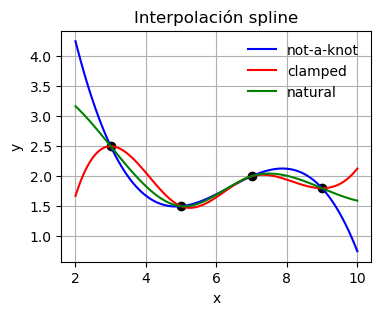

In [17]:
showplot4()

```CubicSpline``` además nos permite determinar las derivadas de la función de interpolación. Para esto, debemos incluir un índice en el segundo argumento de la función generada:
```python
from scipy.interpolate import CubicSpline
y = CubicSpline(xi,yi) # Generamos la función de interpolación

# Derivadas
y(x,1) # Primera derivada
y(x,2) # Segunda derivada
y(x,3) # Tercera derivada
```

Debido a que ```CubicSpline``` está basada en un polinomio de interpolación cúbico, **solo admite hasta la tercera derivada**.

In [18]:
%%capture showplot5
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import numpy as np

xi = np.linspace(-2*np.pi,2*np.pi,20)
yi = np.sin(xi)

# spline "not a knot"
y_1 = CubicSpline(xi,yi)

plt.figure(figsize = (4, 3))           # Tamaño de figura
plt.rcParams.update({'font.size': 10}) # Tamaño de fuente

x = np.linspace(-2*np.pi,2*np.pi,100) # arreglo para graficar

plt.plot(x, y_1(x), '--k',label=r"$y(x)$")     # graficamos la función
plt.plot(x, y_1(x,1), '-b',label=r"$y'(x)$")   # primera derivada
plt.plot(x, y_1(x,2), '-r',label=r"$y''(x)$")  # segunda derivada
plt.plot(x, y_1(x,3), '-g',label=r"$y'''(x)$") # segunda derivada

plt.title('Derivadas interpolación spline')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2,2)
plt.grid()
plt.legend()
plt.show()

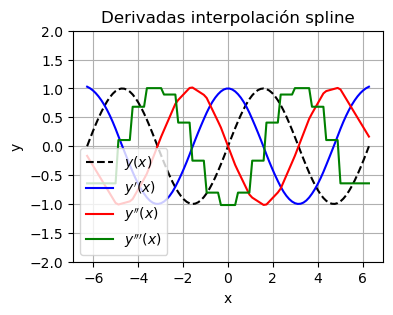

In [19]:
showplot5()

Por defecto, ```CubicSpline``` extrapola los valores fuera de los valores extremos. Podemos suprimir la extrapolación mediante la instrucción ```extrapolate=False```. En este caso, la función entregará ```NaN``` para los valores extrapolados.

In [20]:
%%capture showplot6
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import numpy as np

xi = np.array([  3,   5,   7,   9])
yi = np.array([2.5, 1.5, 2.0, 1.8])

# spline "not a knot" sin extrapolación
y_1 = CubicSpline(xi,yi,extrapolate=False)

plt.figure(figsize = (4, 3))           # Tamaño de figura
plt.rcParams.update({'font.size': 10}) # Tamaño de fuente

x = np.linspace(2,10,100) # arreglo para graficar

plt.plot(xi, yi, 'ok')     # graficamos los xi, yi
plt.plot(x, y_1(x), '-b')  # graficamos la función

plt.title('Interpolación spline')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

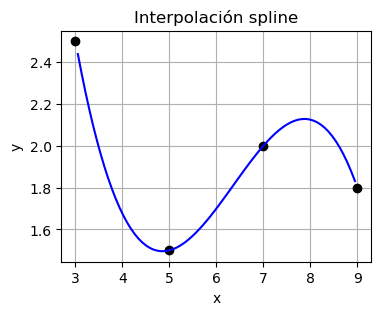

In [21]:
showplot6()

## Referencias
- Kong Q., Siauw T., Bayen A. M. **Chapter 16: Interpolation** in *[Python Programming and Numerical Methods – A Guide for Engineers and Scientists](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter17.00-Interpolation.html)*, 1st Ed., Academic Press, 2021

- Chapra S., Canale R. **Capítulo 18: Interpolación** en *Métodos Numéricos para Ingenieros*, 6ta Ed., McGraw Hill, 2011